### Importing Libraries

In [130]:
import os
import numpy as np
#import pandas as pd
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display

In [135]:
import torch
from torch import Tensor
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary
from transforms import Normalize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cpu


### Define Datasets and Dataloaders

In [136]:
dataset_path = 'data/squares/labeled'

#mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
#std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)


# Transformation function to be applied on images
# 1. Horizontally Flip the image with a probability of 30%
# 2. Randomly Rotate the image at an angle between -40 to 40 degress.
# 3. Resize each images to a smallest size of 300 pixels maintaining aspect ratio
# 4. Crop a square of size 256x256 from the center of image
# 5. Convert Image to a Pytorch Tensor
# 6. Normalize the pytorch's tensor using mean & std of imagenet
transform = transforms.Compose([
#    transforms.RandomHorizontalFlip(p=0.3),
#    transforms.RandomRotation(degrees=40),

    transforms.Resize(100),
    transforms.CenterCrop(95),
    torchvision.transforms.Resize(80),

    transforms.ToTensor(),
    Normalize(),
])

# Create a dataset by from the dataset folder by applying the above transformation.
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
print(dataset.class_to_idx)
# Split the dataset into train & test containing 21000 and 5179 images respectively.
train_size = len(dataset) // 30
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (len(dataset)-train_size, train_size))

# Create a Train DataLoader using Train Dataset
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)
# Create a Test DataLoader using Test Dataset
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

print(len(train_dataloader), len(test_dataloader))


{'black': 0, 'empty': 1, 'white': 2}
603 21


### Plot Some Samples of data

In [140]:
figsize = (16,16)

def PlotSamples(dataloader, title='Images'):
    sample_data = next(iter(dataloader))[0].to(device)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        sample_data, padding=2, normalize=True
    ).cpu(), (1,2,0)))


def PlotClass(dataloader, mclass, title='Images', num=64):
    ret = []

    for data in dataloader.dataset:
        if data[1] == mclass:
            ret.append(data[0])

            if len(ret) == num:
                break

    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        ret, padding=2, normalize=True
    ).cpu(), (1,2,0)))


Exception ignored in: <function StorageWeakRef.__del__ at 0x115517d30>
Traceback (most recent call last):
  File "/Users/boerni/virtualenvs/acid-chess-LXf4eeM8/lib/python3.9/site-packages/torch/multiprocessing/reductions.py", line 36, in __del__
    self._free_weak_ref(self.cdata)
AttributeError: 'StorageWeakRef' object has no attribute '_free_weak_ref'


>>>> torch.Size([4, 3, 80, 80])


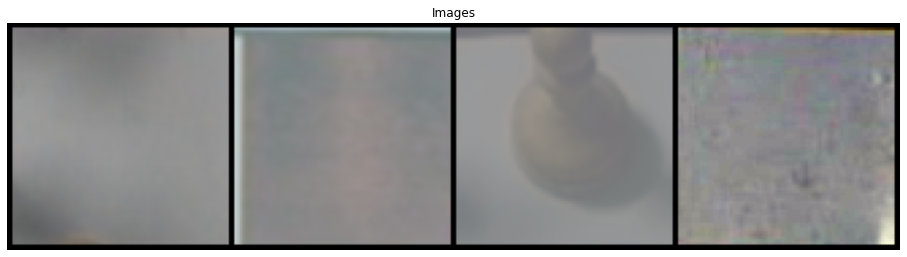

In [141]:
PlotSamples(train_dataloader)
print(">>>>", next(iter(train_dataloader))[0].to(device).shape)


### Defile Model Architecture

In [142]:
from models import SquareClassificationModel

model = SquareClassificationModel().to(device)
summary(model, (3,80,80))





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 78, 78]             140
              ReLU-2            [-1, 5, 78, 78]               0
            Conv2d-3            [-1, 5, 76, 76]             230
              ReLU-4            [-1, 5, 76, 76]               0
         MaxPool2d-5            [-1, 5, 38, 38]               0
            Conv2d-6           [-1, 10, 36, 36]             460
              ReLU-7           [-1, 10, 36, 36]               0
            Conv2d-8           [-1, 10, 34, 34]             910
              ReLU-9           [-1, 10, 34, 34]               0
        MaxPool2d-10           [-1, 10, 17, 17]               0
           Conv2d-11           [-1, 20, 15, 15]           1,820
             ReLU-12           [-1, 20, 15, 15]               0
           Conv2d-13           [-1, 20, 13, 13]           3,620
             ReLU-14           [-1, 20,

### Training Procedure

In [110]:
def Train(epoch, print_every=50):
    total_loss = 0
    start_time = time()

    accuracy = []

    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas

        moutput = model(minput) # output by our model

        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters

        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time
            ))

    return total_loss / len(train_dataloader) # Returning Average Training Loss

### Testing Procedure

In [143]:
def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []

    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_dataloader):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
            moutput = model(minput) # output by our model

            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()


            # To get the probabilities for different classes we need to apply a softmax operation on moutput
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets

    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return total_loss/len(test_dataloader) # Returning Average Testing Loss

### Model, Optimizer & Loss Function

In [144]:
lr = 0.0001
model = SquareClassificationModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
Test(0)

train_loss = []
test_loss = []

for epoch in range(1, 101):
    train_loss.append(Train(epoch,200))
    test_loss.append(Test(epoch))

    print('\n')

    if epoch % 10 == 0:
        torch.save(model.state_dict(), 'model_'+str(epoch)+'.pth')

Epoch: [0], Test Loss: 1.0834, Accuracy: 0.49, Time: 12.61 sec
Epoch: [1]/(200/603), Train Loss: 0.9164, Accuracy: 0.48, Time: 6.80 sec
Epoch: [1]/(400/603), Train Loss: 0.4061, Accuracy: 0.58, Time: 11.48 sec
Epoch: [1]/(600/603), Train Loss: 0.5581, Accuracy: 0.62, Time: 16.03 sec
Epoch: [1], Test Loss: 0.5979, Accuracy: 0.72, Time: 12.84 sec


Epoch: [2]/(200/603), Train Loss: 0.6888, Accuracy: 0.72, Time: 6.99 sec
Epoch: [2]/(400/603), Train Loss: 0.6495, Accuracy: 0.75, Time: 11.39 sec
Epoch: [2]/(600/603), Train Loss: 0.5326, Accuracy: 0.76, Time: 16.42 sec
Epoch: [2], Test Loss: 0.5035, Accuracy: 0.81, Time: 12.51 sec


Epoch: [3]/(200/603), Train Loss: 0.7224, Accuracy: 0.79, Time: 8.12 sec
Epoch: [3]/(400/603), Train Loss: 0.4245, Accuracy: 0.81, Time: 13.46 sec
Epoch: [3]/(600/603), Train Loss: 0.4873, Accuracy: 0.82, Time: 18.66 sec
Epoch: [3], Test Loss: 0.4114, Accuracy: 0.85, Time: 12.47 sec


Epoch: [4]/(200/603), Train Loss: 0.6207, Accuracy: 0.81, Time: 6.70 sec
Epoch:

In [ ]:
### Plot Train-Test Loss Curve

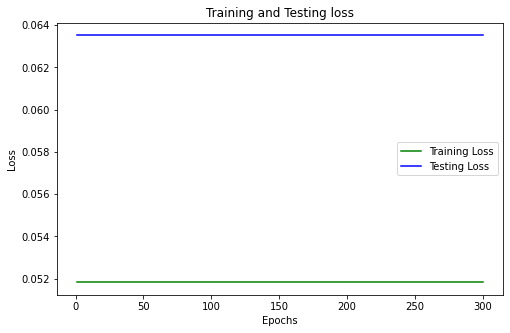

In [119]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss)+1), train_loss, 'g', label='Training Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, 'b', label='Testing Loss')

plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() 

### Test on some random images

data/squares/labeled/black/0058-h-b_0_3.jpeg


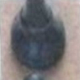

empty : 85 % 


data/squares/labeled/black/9fef5838-4fbb-11ec-ba71-f40f243ba316.jpeg


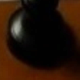

black : 68 % 


data/squares/labeled/black/0010-h-b_1_3.jpeg


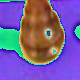

black : 50 % 


data/squares/labeled/black/0010-h-b_1_1.jpeg


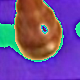

black : 82 % 


data/squares/labeled/black/0003-h-b_0_2.jpeg


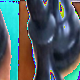

black : 87 % 


data/squares/labeled/black/0048-h-b_1_6.jpeg


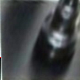

black : 70 % 


data/squares/labeled/black/8df06ba4-4fbb-11ec-ba71-f40f243ba316.jpeg


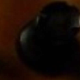

black : 89 % 


data/squares/labeled/black/0010-h-b_0_3.jpeg


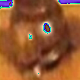

white : 92 % 


data/squares/labeled/black/0010-h-b_1_4.jpeg


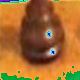

black : 88 % 


data/squares/labeled/black/0019-h-w_6_7.jpeg


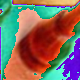

black : 74 % 


data/squares/labeled/black/0063-v-b_6_0.jpeg


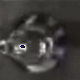

black : 86 % 


data/squares/labeled/black/9ff04518-4fbb-11ec-ba71-f40f243ba316.jpeg


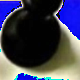

black : 76 % 


data/squares/labeled/black/0010-h-b_0_5.jpeg


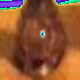

white : 56 % 


data/squares/labeled/black/0029-h-w_7_3.jpeg


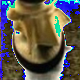

black : 50 % 


data/squares/labeled/black/0058-h-b_0_1.jpeg


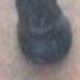

empty : 59 % 


data/squares/labeled/black/0063-v-b_5_1.jpeg


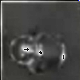

empty : 70 % 


data/squares/labeled/black/0026-v-b_1_0.jpeg


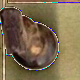

black : 77 % 


data/squares/labeled/black/0015-h-b_1_0.jpeg


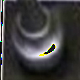

black : 87 % 


data/squares/labeled/black/0003-h-b_1_7.jpeg


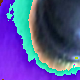

black : 72 % 


data/squares/labeled/black/0060-h-b_1_3.jpeg


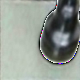

black : 79 % 


data/squares/labeled/black/0010-h-b_1_6.jpeg


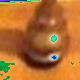

white : 70 % 


data/squares/labeled/black/0051-v-b_2_0.jpeg


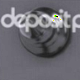

empty : 59 % 


data/squares/labeled/black/0004-h-b_0_1.jpeg


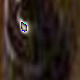

black : 83 % 


data/squares/labeled/black/0012-h-w_7_4.jpeg


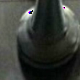

black : 80 % 


data/squares/labeled/black/0043-v-w_3_7.jpeg


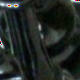

black : 66 % 


data/squares/labeled/black/0044-h-w_6_4.jpeg


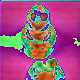

black : 84 % 


data/squares/labeled/black/0010-h-b_1_0.jpeg


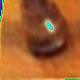

black : 61 % 


data/squares/labeled/black/0043-v-w_6_7.jpeg


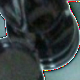

black : 83 % 


data/squares/labeled/black/0063-v-b_7_1.jpeg


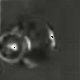

empty : 68 % 


data/squares/labeled/black/0060-h-b_1_0.jpeg


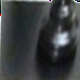

empty : 75 % 


data/squares/labeled/black/0010-h-b_0_1.jpeg


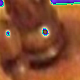

white : 65 % 


data/squares/labeled/black/c4f978f6-508e-11ec-829d-f40f243ba316.jpeg


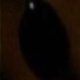

black : 54 % 


data/squares/labeled/black/0010-h-b_0_0.jpeg


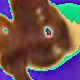

empty : 51 % 


data/squares/labeled/black/0010-h-b_0_6.jpeg


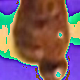

black : 83 % 


data/squares/labeled/black/0051-v-b_4_0.jpeg


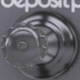

empty : 89 % 


data/squares/labeled/black/0065-h-w_7_6.jpeg


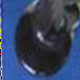

black : 64 % 


data/squares/labeled/black/0060-h-b_1_6.jpeg


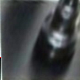

black : 70 % 


data/squares/labeled/black/0ede16fe-4fbb-11ec-ba71-f40f243ba316.jpeg


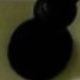

black : 68 % 


data/squares/labeled/black/0010-h-b_1_5.jpeg


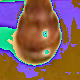

black : 77 % 


data/squares/labeled/black/0048-h-b_1_4.jpeg


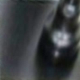

empty : 62 % 


data/squares/labeled/black/0004-h-b_0_3.jpeg


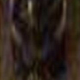

black : 63 % 


data/squares/labeled/black/0010-h-b_0_7.jpeg


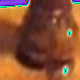

black : 50 % 


data/squares/labeled/black/3847a76e-655e-4e41-ab32-9256a50167eb.jpg


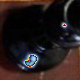

black : 78 % 


data/squares/labeled/black/c4f88cfc-508e-11ec-829d-f40f243ba316.jpeg


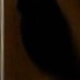

black : 87 % 


data/squares/labeled/black/0063-v-b_2_0.jpeg


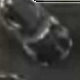

black : 63 % 


data/squares/labeled/black/0065-h-w_7_0.jpeg


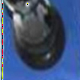

empty : 82 % 


data/squares/labeled/black/0019-h-w_6_6.jpeg


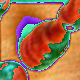

white : 60 % 


data/squares/labeled/black/0010-h-b_0_2.jpeg


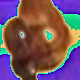

black : 58 % 


data/squares/labeled/black/0060-h-b_1_1.jpeg


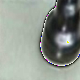

black : 70 % 


data/squares/labeled/black/0060-h-b_1_7.jpeg


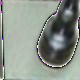

black : 82 % 


data/squares/labeled/black/8ee671ca-4fbb-11ec-ba71-f40f243ba316.jpeg


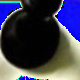

black : 77 % 


data/squares/labeled/black/0058-h-b_1_0.jpeg


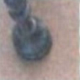

empty : 94 % 


data/squares/labeled/black/9dd1d184-4fbb-11ec-ba71-f40f243ba316.jpeg


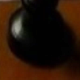

black : 76 % 


data/squares/labeled/black/0010-h-b_1_7.jpeg


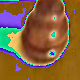

black : 88 % 


data/squares/labeled/black/0065-h-w_7_4.jpeg


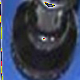

black : 84 % 


data/squares/labeled/black/0001-h-w_7_0.jpeg


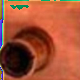

black : 47 % 


data/squares/labeled/black/0012-h-w_7_1.jpeg


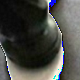

black : 88 % 


data/squares/labeled/black/0048-h-b_1_7.jpeg


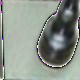

black : 82 % 


data/squares/labeled/black/c7e7527e-fbfd-403f-af28-b1ca15f5cb77.jpg


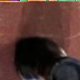

black : 80 % 


data/squares/labeled/black/0063-v-b_3_1.jpeg


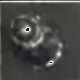

black : 71 % 


data/squares/labeled/black/0060-h-b_1_4.jpeg


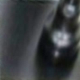

empty : 62 % 


data/squares/labeled/black/0063-v-b_1_1.jpeg


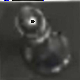

empty : 81 % 


data/squares/labeled/black/0063-v-b_0_0.jpeg


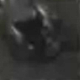

empty : 95 % 


data/squares/labeled/black/0048-h-b_1_3.jpeg


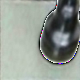

black : 79 % 


data/squares/labeled/black/0003-h-b_0_4.jpeg


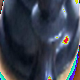

empty : 87 % 


data/squares/labeled/black/0048-h-b_1_1.jpeg


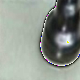

black : 70 % 


data/squares/labeled/black/0048-h-b_1_0.jpeg


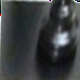

empty : 75 % 


data/squares/labeled/black/0010-h-b_0_4.jpeg


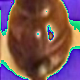

black : 79 % 


data/squares/labeled/black/0015-h-b_0_7.jpeg


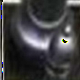

black : 86 % 




In [121]:
# # Uncomment the below two lines if you want to use the pre trained model for 50 epoch
model = SquareClassificationModel()
model.load_state_dict(torch.load('model_50.pth', map_location=device))
#model.cuda()
model.eval()

from glob import glob
from random import shuffle

std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)


denormalize= transforms.Compose([
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToPILImage()
])

classes = ["black", "empty", "white"]

import cv2

expected_class = "black"

with torch.no_grad():
    images = glob(f'data/squares/labeled/{expected_class}/*')  # /content/drive/MyDrive/squares/labeled/white/*
    shuffle(images)
    for impath in images:
        image = cv2.imread(impath)
        image_orig = image.copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        image = torchvision.transforms.Compose([
            torchvision.transforms.Resize(100),
            torchvision.transforms.CenterCrop(95),
            torchvision.transforms.Resize(80),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(image)

        image_tensor = image.view(1, 3, 80, 80).to(device)
        prediction = model(image_tensor)

        predicted_class_id = prediction.argmax().data.item()
        predicted_class = classes[predicted_class_id]

        probability = torch.nn.Softmax(dim=1)(prediction)[0] * 100
        probability = probability.int().data.cpu().numpy()[predicted_class_id]
        if predicted_class != expected_class or probability < 90:
            print(impath)
            display(denormalize(image))
            print(predicted_class, ':', probability, '%', '\n\n')

#model.train()
#pass